In [1]:
import pyomo.environ as pyomo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

INPUT_SOLAR = "../../data/solar.daily.csv"
DEMAND_DATA = "../../data/demand.csv"


In [2]:
df_solar = pd.read_csv(INPUT_SOLAR)
df_solar = df_solar.assign(pv_generation=df_solar["pv_generation"] / 1000.0)
df_solar

,time,pv_generation
0,2018-01-01 00:00:00+00:00,4.074020
1,2018-01-02 00:00:00+00:00,2.586380
2,2018-01-03 00:00:00+00:00,1.675187
3,2018-01-04 00:00:00+00:00,4.348347
4,2018-01-05 00:00:00+00:00,6.306651
...,...,...
360,2018-12-27 00:00:00+00:00,2.340397
361,2018-12-28 00:00:00+00:00,4.188391
362,2018-12-29 00:00:00+00:00,5.071927
363,2018-12-30 00:00:00+00:00,4.434556


In [3]:
df = pd.read_csv(DEMAND_DATA, index_col="t")
df = df.assign(pv_power_single=df_solar["pv_generation"])
demand_arr = df["demand"].to_numpy()
df

,demand,pv_power_single
t,,
0,201.644164,4.074020
1,201.394918,2.586380
2,201.985554,1.675187
3,201.325092,4.348347
4,200.392689,6.306651
...,...,...
360,201.873386,2.340397
361,200.359180,4.188391
362,200.992932,5.071927


In [4]:
# 1. Creating a model ###############
model = pyomo.ConcreteModel()


In [5]:
# 2. Setting Parameters #############
demand_dict = {}
for i, item in enumerate(demand_arr):
    demand_dict[i] = item

solar_dict = {}
for i, item in enumerate(df["pv_power_single"]):
    solar_dict[i] = item

cost_pv_array = (7 * 200 + 1 * 500) / 20.0

model.T = pyomo.Set(initialize=range(len(df)))
model.grid_buy_price = pyomo.Param(initialize=0.3)
model.grid_sell_price = pyomo.Param(initialize=0.2)
model.c_array = pyomo.Param(initialize=cost_pv_array)
model.po_array_single = pyomo.Param(model.T, initialize=solar_dict)
model.demand = pyomo.Param(model.T, initialize=demand_dict)

In [6]:
# 3. Setting Variables ##############
model.v_po_grid = pyomo.Var(model.T, domain=pyomo.NonNegativeReals)
model.v_grid_sell = pyomo.Var(model.T, domain=pyomo.NonNegativeReals)
model.v_i_arrays = pyomo.Var(domain=pyomo.PositiveIntegers)


In [7]:
# 4. Setting Constraints ############
def demand_supply_rule(model, t):
    return (
        model.v_po_grid[t] + model.v_i_arrays * model.po_array_single[t]
        == model.demand[t] + model.v_grid_sell[t]
    )


def initial_cost_rule(model):
    return model.v_i_arrays * model.c_array <= 20000 / 20


model.c_demand_supply = pyomo.Constraint(model.T, rule=demand_supply_rule)
model.c_initial_cost = pyomo.Constraint(rule=initial_cost_rule)

In [8]:
# 5. Setting Objective ##############
def objective_func(model):
    cost = [0] * len(model.T)
    pv_init_cost = model.c_array * model.v_i_arrays
    for i, t in enumerate(model.T):
        grid_buy_cost = model.grid_buy_price * model.v_po_grid[t]
        grid_sell_income = model.grid_sell_price * model.v_grid_sell[t]
        cost[i] = grid_buy_cost - grid_sell_income
    return pv_init_cost + sum(cost)


model.obj = pyomo.Objective(rule=objective_func, sense=pyomo.minimize)

In [9]:
# Solving the Solution ###########
solver = pyomo.SolverFactory("cbc")
result = solver.solve(model)
result

{'Problem': [{'Name': 'unknown', 'Lower bound': 12835.67397787, 'Upper bound': 12835.67397787, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Number of binary variables': 0, 'Number of integer variables': 1, 'Number of nonzeros': 0, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.01, 'Wallclock time': 0.02, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 1}}, 'Error rc': 0, 'Time': 0.0341649055480957}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [10]:
grid_power_arr = np.zeros(len(df))
for i, t in enumerate(model.T):
    grid_power_arr[i] = model.v_po_grid[t]()
grid_power_arr

array([160.90396 , 175.53112 , 185.23369 , 157.84162 , 137.32618 ,
       170.15124 , 139.23185 , 133.1149  , 140.77489 , 140.57253 ,
       141.56539 , 147.4325  , 142.88935 , 149.94814 , 147.6545  ,
       150.36742 , 146.53963 , 155.34691 , 143.01328 , 142.82923 ,
       151.90318 , 151.04359 , 151.07352 , 178.41441 , 157.52198 ,
       123.57584 , 152.0427  , 118.09125 , 120.3421  , 114.24215 ,
       118.38341 , 120.47888 , 115.99019 , 117.21489 , 114.54969 ,
       115.84118 , 112.74869 , 106.76281 , 108.7053  , 147.29305 ,
       102.95736 ,  99.795347,  99.012422, 102.2435  , 105.87189 ,
       130.702   ,  99.46359 , 141.6075  , 162.47093 , 129.93842 ,
       136.82916 , 122.46459 ,  83.481336,  85.006873,  91.672905,
        78.688388, 119.81886 , 180.07841 , 106.1322  , 162.74692 ,
       108.81939 ,  78.778553, 171.18889 , 112.58993 , 174.55273 ,
       129.3818  ,  80.269487,  61.876423,  66.800621,  63.172859,
        62.191489,  63.182793, 100.12616 ,  84.483094, 167.553

In [11]:
df["grid_power"] = grid_power_arr
df

,demand,pv_power_single,grid_power
t,,,
0,201.644164,4.074020,160.90396
1,201.394918,2.586380,175.53112
2,201.985554,1.675187,185.23369
3,201.325092,4.348347,157.84162
4,200.392689,6.306651,137.32618
...,...,...,...
360,201.873386,2.340397,178.46942
361,200.359180,4.188391,158.47527
362,200.992932,5.071927,150.27367


In [12]:
model.v_i_arrays()

10.0

In [13]:
df = df.assign(pv_power=model.v_i_arrays() * df["pv_power_single"])
df

,demand,pv_power_single,grid_power,pv_power
t,,,,
0,201.644164,4.074020,160.90396,40.740203
1,201.394918,2.586380,175.53112,25.863796
2,201.985554,1.675187,185.23369,16.751869
3,201.325092,4.348347,157.84162,43.483468
4,200.392689,6.306651,137.32618,63.066510
...,...,...,...,...
360,201.873386,2.340397,178.46942,23.403969
361,200.359180,4.188391,158.47527,41.883915
362,200.992932,5.071927,150.27367,50.719266


In [14]:
model.obj()

12835.6739624

<Axes: xlabel='t'>

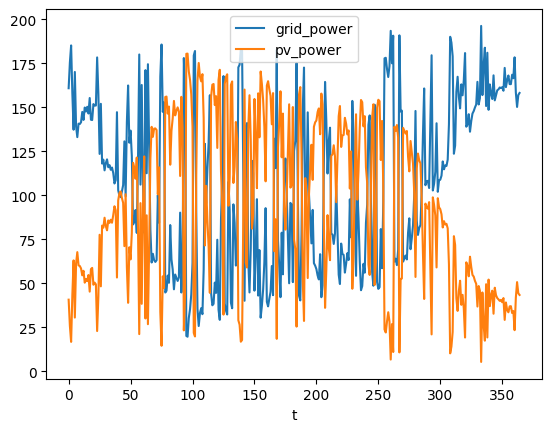

In [15]:
df[["grid_power", "pv_power"]].plot()